# Nibabel data
Masks saved as picked sparce scipy matrixes to improve loading speed and size on disk.

In [11]:
import shutil

import os
import glob
import nibabel as nib

import cv2
import numpy as np
import sparse
import pickle

def save_sparce_npz(path:str,array):
    '''
    Saves npy array as sparce pickled scipy matrix.
    '''
    s = sparse.COO(array)
    
    #Pickle dump
    with open(path,'wb') as file:
        pickle.dump(s, file)
    
def prepare_single_patient_nii(data_dir:str,target_dir:str,label:int,take_every_nth:int):
    for file in os.listdir(data_dir):
        if file.startswith("P"):
            images = nib.load(os.path.join(data_dir, file)).get_fdata()
            filename = file.split('.')[0]
        if file.startswith("G"):
            masks = nib.load(os.path.join(data_dir, file)).get_fdata()
    
    
        
    if images is None or file is None:
        print(f'Input folder error: one of file not found.\nDirectory: {data_dir}')
        raise 
    
    im_dir = os.path.join(target_dir,'images')
    msk_dir = os.path.join(target_dir,'masks')
    
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)
    if not os.path.exists(im_dir):
        os.makedirs(im_dir)
    if not os.path.exists(msk_dir):
        os.makedirs(msk_dir)
    
    slice_indexes = np.array(range(images.shape[2]))[::take_every_nth]
    # taking n-th images and masks
    images = images[:,:,::take_every_nth]
    masks = masks[:,:,::take_every_nth]
    # swapping axes for easy iteration
    images = np.swapaxes(images,0,2)
    masks = np.swapaxes(masks,0,2)
    
    for idx,image, mask in zip(slice_indexes,images,masks):
        if label in mask:
            im_name = os.path.join(im_dir,filename+'_'+str(idx)+'.jpg')
            msk_name = os.path.join(msk_dir,filename+'_'+str(idx)+'.pickle')
            cv2.imwrite(im_name, image)
            save_sparce_npz(msk_name,(mask == label).astype(float))
    
def prepare_images_nii(folders_dir:str,target_dir:str,wanted_label_idx:int,take_every_nth:int=10):
    
    for root, dirs, files in os.walk(folders_dir):
        for d in dirs:
            prepare_single_patient_nii(os.path.join(root,d),target_dir,wanted_label_idx,take_every_nth)
    

In [12]:
data = #insert path to raw data
where = # output path
prepare_images_nii(data,where,4,take_every_nth=5)

# Nibabel data in one folder

In [1]:
import shutil

import os
import glob
import nibabel as nib

import zipfile
import re

import cv2
import numpy as np
import sparse
import pickle
from tqdm import tqdm

def save_sparce_npz(path:str,array):
    '''
    Saves npy array as sparce pickled scipy matrix.
    '''
    s = sparse.COO(array)
    
    #Pickle dump
    with open(path,'wb') as file:
        pickle.dump(s, file)
        
def prepare_channeled_labels(mask,labels:list):
    new_mask_temp = []
    for label in labels:
        label_mask = (mask == label).astype(float)
        new_mask_temp.append(label_mask)
    return np.array(new_mask_temp)

def contains_any_from_list(lst:list,array):
    for elem in lst:
        if elem in array:
            return True
    return False

def filename_formatter(file_path:str):
    '''Extracts filename from file path.
    Hardcoded to concrete file naming format'''
    full_filename = os.path.basename(file_path)
    filename = full_filename.split('_')[0]
    return filename

def prepare_pair(pair_of_paths,target_dir:str,wanted_labels:list,take_every_nth:int):
    for file in pair_of_paths:
        if '_label.nii' in file:
            masks = nib.load(file).get_fdata()
        else:
            images = nib.load(file).get_fdata()
            filename = filename_formatter(file)
        
    
        
    if images is None or masks is None:
        print(f'Input folder error: one of file not found.\nDirectory: {data_dir}')
        raise 
    
    im_dir = os.path.join(target_dir,'images')
    msk_dir = os.path.join(target_dir,'masks')
    
    slice_indexes = np.array(range(images.shape[2]))[::take_every_nth]
    # taking n-th images and masks
    images = images[:,:,::take_every_nth]
    masks = masks[:,:,::take_every_nth]
    
    # swapping axes for easy iteration
    images = np.swapaxes(images,0,2)
    masks = np.swapaxes(masks,0,2)
    
    for idx,image, mask in zip(slice_indexes,images,masks):
        if contains_any_from_list(wanted_labels,mask):
            im_name = os.path.join(im_dir,filename+'_'+str(idx)+'.jpg')
            msk_name = os.path.join(msk_dir,filename+'_'+str(idx)+'.pickle')
            
            image = cv2.normalize(image, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
            cv2.imwrite(im_name, image)
            
            temp_mask = prepare_channeled_labels(mask,wanted_labels)
            save_sparce_npz(msk_name,temp_mask)

            
def listdir_fullpath(d):
    return [os.path.join(d, f) for f in os.listdir(d)]

def find_file_pairs(filenames):
    prefixes = {}

    for f in filenames:
        m = re.search('.+(?=label|image)', f)
        if m:
            prefix = m.group(0)
            #print(prefix)
            if prefix in prefixes:
                prefixes[prefix].append(f)
            else:
                prefixes[prefix] = [f]

    return list(prefixes.values())
        
def prepare_nii_images_from_folder(data_dir:str,target_dir:str,wanted_labels:list,take_every_nth:int=10):
    
    # creates list of pairs containing full file paths to images and labels
    file_names = listdir_fullpath(data_dir)
    pairs_lst = find_file_pairs(file_names)

    # preparing output directories
    im_dir = os.path.join(target_dir,'images')
    msk_dir = os.path.join(target_dir,'masks')

    if not os.path.exists(target_dir):
        os.makedirs(target_dir)
    if not os.path.exists(im_dir):
        os.makedirs(im_dir)
    if not os.path.exists(msk_dir):
        os.makedirs(msk_dir)


    for pair in tqdm(pairs_lst):
        prepare_pair(pair,target_dir=target_dir,wanted_labels=wanted_labels,take_every_nth=take_every_nth)

In [2]:
def load_sparce_npz(path:str):
    '''
    Loads npy array as sparce pickled scipy matrix.
    '''
    with open(path,'rb') as file:
        s = pickle.load(file)
    
    return s.todense()

In [20]:
data = #insert path to raw data
where = # output path
prepare_nii_images_from_folder(data,where,wanted_labels=[1,2,3],take_every_nth=4)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [10:06<00:00,  6.06s/it]


# Merging flows for aorta

In [5]:
i = nib.load(r"E:\University\ScienceWork\Medicine\AortaStuff\ML\raw_data\imageTBAD\Copy101_image.nii.gz").get_fdata()

In [14]:
m = nib.load(r"E:\University\ScienceWork\Medicine\AortaStuff\ML\raw_data\imageTBAD\Copy83_label.nii.gz").get_fdata()

In [15]:
m.shape

(512, 512, 480)

In [16]:
SLICE_NUM = 228

(-0.5, 511.5, 511.5, -0.5)

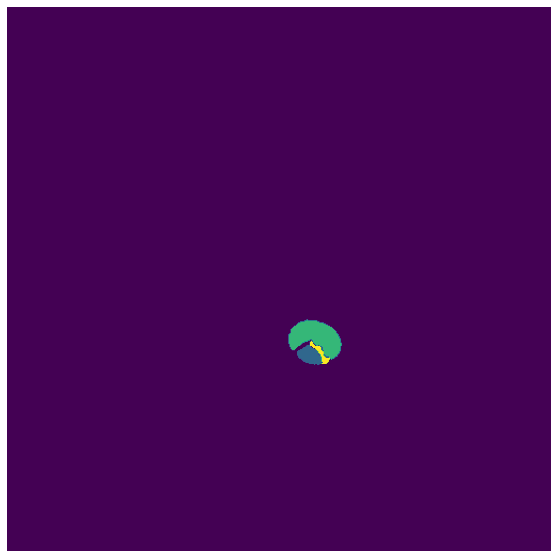

In [17]:
plt.figure(figsize = (10,10))
plt.imshow(m[:,:,SLICE_NUM])
plt.axis('off')

In [19]:
msk = m[:,:,SLICE_NUM]
msk[msk>0] = 255

(-0.5, 511.5, 511.5, -0.5)

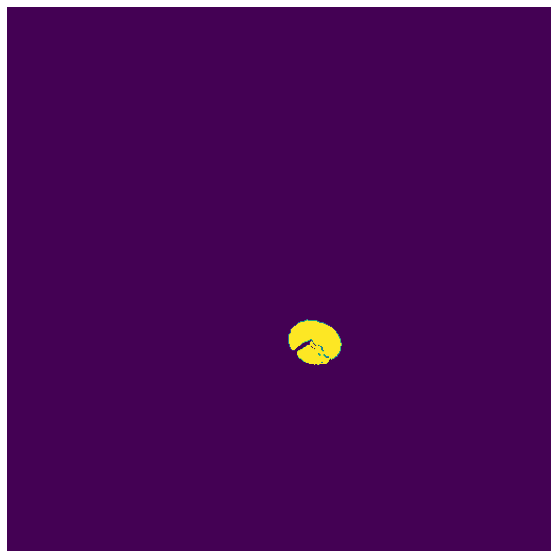

In [20]:
plt.figure(figsize = (10,10))
plt.imshow(msk)
plt.axis('off')

In [21]:
def dilate_erode(image,kernel_size_dil = 8,kernel_size_er = 5):
    img_dir = cv2.dilate(image,np.ones((kernel_size_dil,kernel_size_dil), np.uint8))
    img_new = cv2.erode(msk_dil,np.ones((kernel_size_er,kernel_size_er), np.uint8))
    return img_new

In [22]:
msk_new = dilate_erode(msk)

NameError: name 'msk_dil' is not defined

In [24]:
msk_dil = cv2.dilate(msk,np.ones((8,8), np.uint8))

(-0.5, 511.5, 511.5, -0.5)

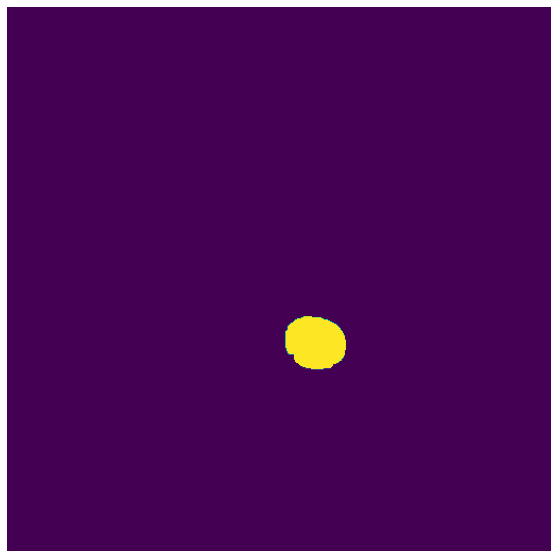

In [25]:
plt.figure(figsize = (10,10))
plt.imshow(msk_dil)
plt.axis('off')

In [26]:
msk_er = cv2.erode(msk_dil,np.ones((5,5), np.uint8))

(-0.5, 511.5, 511.5, -0.5)

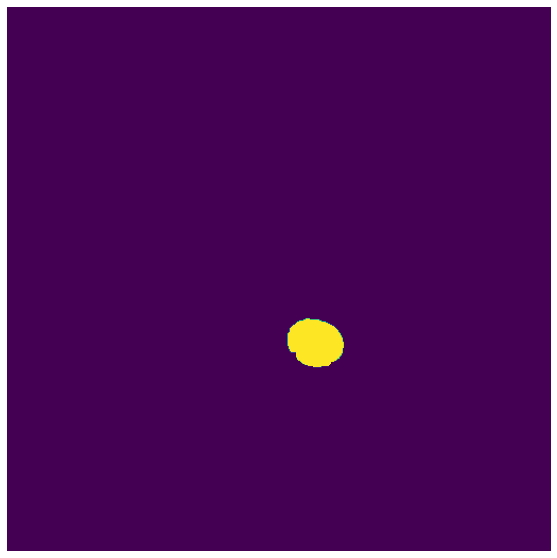

In [29]:
plt.figure(figsize = (10,10))
plt.imshow(msk_er)
plt.axis('off')

(-0.5, 511.5, 511.5, -0.5)

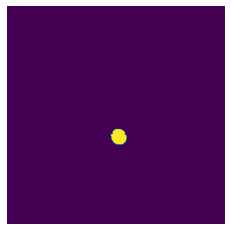

In [33]:
plt.imshow(msk_new)
plt.axis('off')

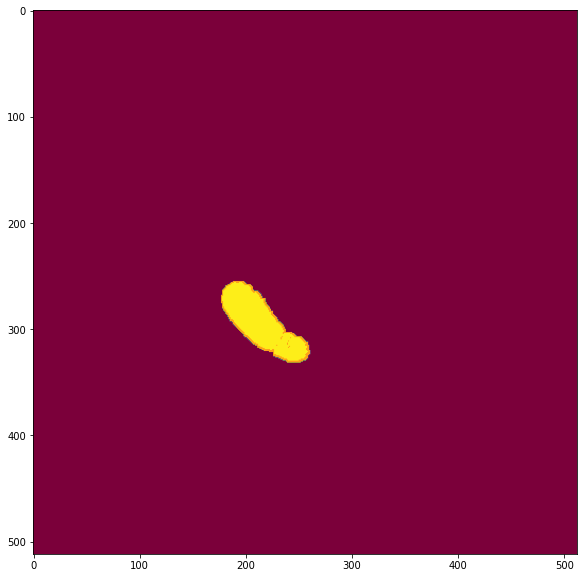

In [135]:
plt.figure(figsize = (10,10))
plt.imshow(msk_new)
plt.imshow(msk, alpha=0.3,cmap = 'autumn')

In [130]:
img = i[:,:,SLICE_NUM]

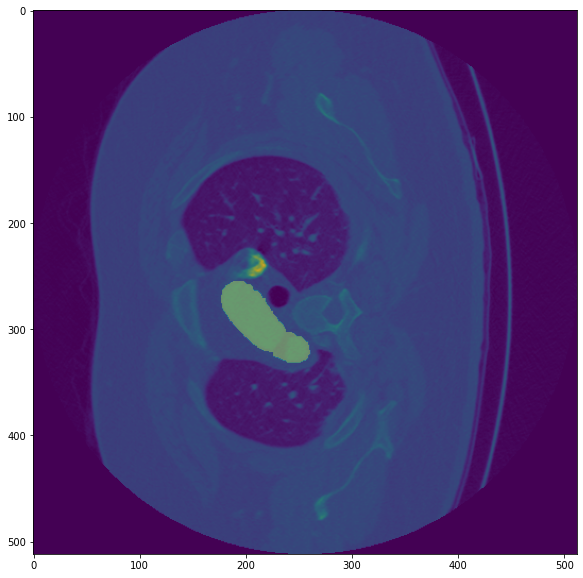

In [136]:
plt.figure(figsize = (10,10))
plt.imshow(img)
plt.imshow(msk_new, alpha=0.3)

In [148]:
img = cv2.normalize(img, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
image_3c = np.array([img,img,msk_new*255])
image_3c = np.transpose(image_3c,[1,2,0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


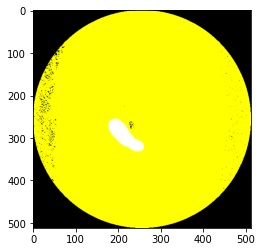

In [149]:
plt.imshow(image_3c)

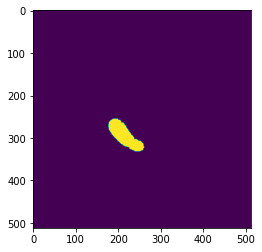

In [155]:
plt.imshow(image_3c[:,:,2])

In [156]:
def add_bonus_channel(image,mask):
    image_3c = np.array([image,image,mask])
    image_3c = np.transpose(image_3c,[1,2,0])
    return image_3c

## Code

In [18]:
import shutil

import os
import glob
import nibabel as nib

import zipfile
import re

import cv2
import numpy as np
import sparse
import pickle
from tqdm import tqdm

def save_sparce_npz(path:str,array):
    '''
    Saves npy array as sparce pickled scipy matrix.
    '''
    s = sparse.COO(array)
    
    #Pickle dump
    with open(path,'wb') as file:
        pickle.dump(s, file)
        
def prepare_channeled_labels(mask,labels:list):
    new_mask_temp = []
    for label in labels:
        label_mask = (mask == label).astype(float)
        new_mask_temp.append(label_mask)
    return np.array(new_mask_temp)

def contains_any_from_list(lst:list,array):
    for elem in lst:
        if elem in array:
            return True
    return False

def filename_formatter(file_path:str):
    '''Extracts filename from file path.
    Hardcoded to concrete file naming format'''
    full_filename = os.path.basename(file_path)
    filename = full_filename.split('_')[0]
    return filename

def add_bonus_channel(image,mask):
    image_3c = np.array([image,image,mask])
    image_3c = np.transpose(image_3c,[1,2,0])
    return image_3c

def dilate_erode(image,kernel_size_dil = 8,kernel_size_er = 5):
    img_dil = cv2.dilate(image,np.ones((kernel_size_dil,kernel_size_dil), np.uint8))
    img_new = cv2.erode(img_dil,np.ones((kernel_size_er,kernel_size_er), np.uint8))
    return img_new

def prepare_mask_as_channel(mask):
    new_mask = np.copy(mask)
    new_mask[new_mask>0] = 1
    
    new_mask = dilate_erode(new_mask)
    return new_mask

def prepare_pair_add_aorta(pair_of_paths,target_dir:str,wanted_labels:list,take_every_nth:int):
    for file in pair_of_paths:
        if '_label.nii' in file:
            masks = nib.load(file).get_fdata()
        else:
            images = nib.load(file).get_fdata()
            filename = filename_formatter(file)
        
        
    if images is None or masks is None:
        print(f'Input folder error: one of file not found.\nDirectory: {data_dir}')
        raise 
    
    im_dir = os.path.join(target_dir,'images')
    msk_dir = os.path.join(target_dir,'masks')
    
    slice_indexes = np.array(range(images.shape[2]))[::take_every_nth]
    # taking n-th images and masks
    images = images[:,:,::take_every_nth]
    masks = masks[:,:,::take_every_nth]
    
    # swapping axes for easy iteration
    images = np.swapaxes(images,0,2)
    masks = np.swapaxes(masks,0,2)
    
    for idx,image, mask in zip(slice_indexes,images,masks):
        if contains_any_from_list(wanted_labels,mask):
            im_name = os.path.join(im_dir,filename+'_'+str(idx)+'.jpg')
            msk_name = os.path.join(msk_dir,filename+'_'+str(idx)+'.pickle')
            
            image = cv2.normalize(image, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
            aorta_ch = prepare_mask_as_channel(mask)
            image_3c = add_bonus_channel(image,aorta_ch*255)
            cv2.imwrite(im_name, image_3c)
            
            temp_mask = prepare_channeled_labels(mask,wanted_labels)
            save_sparce_npz(msk_name,temp_mask)

            
def listdir_fullpath(d):
    return [os.path.join(d, f) for f in os.listdir(d)]

def find_file_pairs(filenames):
    prefixes = {}

    for f in filenames:
        m = re.search('.+(?=label|image)', f)
        if m:
            prefix = m.group(0)
            #print(prefix)
            if prefix in prefixes:
                prefixes[prefix].append(f)
            else:
                prefixes[prefix] = [f]

    return list(prefixes.values())
        
def prepare_nii_images_from_folder_with_aorta(data_dir:str,target_dir:str,wanted_labels:list,take_every_nth:int=10):
    
    # creates list of pairs containing full file paths to images and labels
    file_names = listdir_fullpath(data_dir)
    pairs_lst = find_file_pairs(file_names)

    # preparing output directories
    im_dir = os.path.join(target_dir,'images')
    msk_dir = os.path.join(target_dir,'masks')

    if not os.path.exists(target_dir):
        os.makedirs(target_dir)
    if not os.path.exists(im_dir):
        os.makedirs(im_dir)
    if not os.path.exists(msk_dir):
        os.makedirs(msk_dir)


    for pair in tqdm(pairs_lst):
        prepare_pair_add_aorta(pair,target_dir=target_dir,wanted_labels=wanted_labels,take_every_nth=take_every_nth)

In [26]:
data = #insert path to raw data
where = # output path
prepare_nii_images_from_folder_with_aorta(data,where,wanted_labels=[1,2,3],take_every_nth=4)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [12:15<00:00,  7.35s/it]


# Only aorta

In [37]:
import shutil

import os
import glob
import nibabel as nib

import zipfile
import re

import cv2
import numpy as np
import sparse
import pickle
from tqdm import tqdm

def save_sparce_npz(path:str,array):
    '''
    Saves npy array as sparce pickled scipy matrix.
    '''
    s = sparse.COO(array)
    
    #Pickle dump
    with open(path,'wb') as file:
        pickle.dump(s, file)
        
def prepare_channeled_labels(mask,labels:list):
    new_mask_temp = []
    for label in labels:
        label_mask = (mask == label).astype(float)
        new_mask_temp.append(label_mask)
    return np.array(new_mask_temp)

def contains_any_from_list(lst:list,array):
    for elem in lst:
        if elem in array:
            return True
    return False

def filename_formatter(file_path:str):
    '''Extracts filename from file path.
    Hardcoded to concrete file naming format'''
    full_filename = os.path.basename(file_path)
    filename = full_filename.split('_')[0]
    return filename

def add_bonus_channel(image,mask):
    image_3c = np.array([image,image,mask])
    image_3c = np.transpose(image_3c,[1,2,0])
    return image_3c

def dilate_erode(image,kernel_size_dil = 8,kernel_size_er = 5):
    img_dil = cv2.dilate(image,np.ones((kernel_size_dil,kernel_size_dil), np.uint8))
    img_new = cv2.erode(img_dil,np.ones((kernel_size_er,kernel_size_er), np.uint8))
    return img_new

def prepare_mask_as_channel(mask):
    new_mask = np.copy(mask)
    new_mask[new_mask>0] = 1
    
    new_mask = dilate_erode(new_mask)
    return new_mask

def prepare_pair_only_aorta(pair_of_paths,target_dir:str,wanted_labels:list,take_every_nth:int):
    for file in pair_of_paths:
        if '_label.nii' in file:
            masks = nib.load(file).get_fdata()
        else:
            images = nib.load(file).get_fdata()
            filename = filename_formatter(file)
        
        
    if images is None or masks is None:
        print(f'Input folder error: one of file not found.\nDirectory: {data_dir}')
        raise 
    
    im_dir = os.path.join(target_dir,'images')
    msk_dir = os.path.join(target_dir,'masks')
    
    slice_indexes = np.array(range(images.shape[2]))[::take_every_nth]
    # taking n-th images and masks
    images = images[:,:,::take_every_nth]
    masks = masks[:,:,::take_every_nth]
    
    # swapping axes for easy iteration
    images = np.swapaxes(images,0,2)
    masks = np.swapaxes(masks,0,2)
    
    for idx,image, mask in zip(slice_indexes,images,masks):
        if contains_any_from_list(wanted_labels,mask):
            im_name = os.path.join(im_dir,filename+'_'+str(idx)+'.jpg')
            msk_name = os.path.join(msk_dir,filename+'_'+str(idx)+'.pickle')
            
            image = cv2.normalize(image, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
            
            cv2.imwrite(im_name, image)
            
            aorta_ch = prepare_mask_as_channel(mask)
            save_sparce_npz(msk_name,aorta_ch)

            
def listdir_fullpath(d):
    return [os.path.join(d, f) for f in os.listdir(d)]

def find_file_pairs(filenames):
    prefixes = {}

    for f in filenames:
        m = re.search('.+(?=label|image)', f)
        if m:
            prefix = m.group(0)
            #print(prefix)
            if prefix in prefixes:
                prefixes[prefix].append(f)
            else:
                prefixes[prefix] = [f]

    return list(prefixes.values())
        
def prepare_nii_images_from_folder_only_aorta(data_dir:str,target_dir:str,wanted_labels:list,take_every_nth:int=10):
    
    # creates list of pairs containing full file paths to images and labels
    file_names = listdir_fullpath(data_dir)
    pairs_lst = find_file_pairs(file_names)

    # preparing output directories
    im_dir = os.path.join(target_dir,'images')
    msk_dir = os.path.join(target_dir,'masks')

    if not os.path.exists(target_dir):
        os.makedirs(target_dir)
    if not os.path.exists(im_dir):
        os.makedirs(im_dir)
    if not os.path.exists(msk_dir):
        os.makedirs(msk_dir)


    for pair in tqdm(pairs_lst):
        prepare_pair_only_aorta(pair,target_dir=target_dir,wanted_labels=wanted_labels,take_every_nth=take_every_nth)

In [38]:
data = #insert path to raw data
where = # output path
prepare_nii_images_from_folder_only_aorta(data,where,wanted_labels=[1,2],take_every_nth=4)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [10:09<00:00,  6.09s/it]


# Separating validation files

In [21]:
import os

def contains_any_from_list(lst:list,array):
    for elem in lst:
        if elem in array:
            return True
    return False

def validation_separation(old_directory:str,new_directory:str,wanted_name_piece:list):
    
    original_filenames = os.listdir(old_directory)
    
    
    wanted_filenames = [name for name in original_filenames if any(piece in name for piece in wanted_name_piece)]
    old_wanted_paths = [os.path.join(old_directory, f) for f in wanted_filenames]
    new_wanted_paths = [os.path.join(new_directory, f) for f in wanted_filenames]

    for old,new in zip(old_wanted_paths,new_wanted_paths):
        os.rename(old,new)

In [16]:
files_directory = # input
new_dir = # output
# files to move from input to output
wanted_files = ['Patient_03','Patient_06','Patient_18','Patient_25','Patient_26','Patient_35']

validation_separation(files_directory,new_dir,wanted_files)

In [28]:
files_directory = # input
new_dir = # output
# files to move from input to output
wanted_files = ['Copy7_','Copy26','Copy40','Copy42','Copy43','Copy44','Copy51','Copy63','Copy66','Copy75','Copy98','Copy102','Copy112','Copy126','Copy127','Copy136','Copy143','Copy162','Copy181',]

validation_separation(files_directory,new_dir,wanted_files)

# Renaming files

In [23]:
import os

def rename_exchange(directory:str,old_name_piece:str,new_name_piece:str):
    
    original_filenames = os.listdir(directory)
    
    full_original_filenames = [os.path.join(directory, f) for f in original_filenames]
    full_new_filenames = [os.path.join(directory,name.replace(old_name_piece,new_name_piece)) for name in original_filenames]

    for old,new in zip(full_original_filenames,full_new_filenames):
        os.rename(old,new)

In [24]:
rename_exchange('path to files','Копия ','Copy')